In [1109]:
from matplotlib import pyplot as plt
import math
import json
import numpy as np
import pandas as pd
from collections import OrderedDict

pcolors = OrderedDict([('blue', [0.00, 0.33, 0.66]),
                       ('green', [0.33, 0.66, 0.00]),
                       ('red', [0.66, 0.00, 0.00]),
                       ('cyan', [0.00, 0.66, 0.66]),
                       ('grey', [0.25, 0.5, 0.5]),
                       ('purple', [0.33, 0.00, 0.66]),
                       ('orange', [0.7, 0.4, 0.00])])

plt.rcParams['figure.figsize'] = (3.3, 2)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'None'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.dpi'] = 600

%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

rc = %config InlineBackend.rc
rc['savefig.dpi'] = 150
rc['figure.dpi'] = 150

In [1110]:
# setup 
instance = '20a'
policy = 'edge-policy'
t_range = [100., 30., 10., 3., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
p_range = [0.6, 0.7, 0.8, 0.9, 1.0]
num_particles = 1000

lsmh_range = ["smh"] # , "lmh"]
train_range = [1, 2, 5, 10, 20, 50, 100]
test_episodes = 10000
rho = 0.1
gamma = 0.9
kappa = 0.5

baseline_types = ['random-agent', 'optimistic-agent', 'clairvoyant-agent']

results_dir = '../results/ctp/'

In [1111]:
# load instance
instances = json.load(open('../resources/ctp/instances.json', 'r'))

In [1112]:
# load baselines
baseline_path = '%s/ctp-%s-%s-p%.1f-test%d.json' 
baselines = {}
for b in baseline_types:
    baselines[b] = {}
    for p in p_range:
        try:
            filename = baseline_path % (results_dir,b,instance,p,test_episodes)
            baselines[b][p] = json.load(open(filename, 'r'))
            #print '.',
            print(b, p)
        except:
           pass        

random-agent 0.6
random-agent 0.7
random-agent 0.8
random-agent 0.9
random-agent 1.0
optimistic-agent 0.6
optimistic-agent 0.7
optimistic-agent 0.8
optimistic-agent 0.9
optimistic-agent 1.0
clairvoyant-agent 0.6
clairvoyant-agent 0.7
clairvoyant-agent 0.8
clairvoyant-agent 0.9
clairvoyant-agent 1.0


In [1113]:
# load mh trials
trial_path = '%s/ctp-%s-%s-%s-p%.1f-t%.3f-test%d.json'
lsmhtrials = {"lmh": {}, "smh": {}}
for lsmh in lsmh_range:
    for p in p_range:
        lsmhtrials[lsmh][p] = {}
        for t in t_range:
            lsmhtrials[lsmh][p][t] = {}
            try:
                filename = trial_path % (results_dir, lsmh, policy, instance, p, t, test_episodes)
                lsmhtrials[lsmh][p][t] = json.load(open(filename, 'r'))
                #print '.',
                print(lsmh, p, t)
            except Exception as e:
                print(e)
                pass        

smh 0.6 100.0
smh 0.6 30.0
smh 0.6 10.0
smh 0.6 3.0
smh 0.6 1.0
smh 0.6 0.3
smh 0.6 0.1
smh 0.6 0.03
smh 0.6 0.01
smh 0.6 0.003
smh 0.6 0.001
smh 0.7 100.0
smh 0.7 30.0
smh 0.7 10.0
smh 0.7 3.0
smh 0.7 1.0
smh 0.7 0.3
smh 0.7 0.1
smh 0.7 0.03
smh 0.7 0.01
smh 0.7 0.003
smh 0.7 0.001
smh 0.8 100.0
smh 0.8 30.0
smh 0.8 10.0
smh 0.8 3.0
smh 0.8 1.0
smh 0.8 0.3
smh 0.8 0.1
smh 0.8 0.03
smh 0.8 0.01
smh 0.8 0.003
smh 0.8 0.001
smh 0.9 100.0
smh 0.9 30.0
smh 0.9 10.0
smh 0.9 3.0
smh 0.9 1.0
smh 0.9 0.3
smh 0.9 0.1
smh 0.9 0.03
smh 0.9 0.01
smh 0.9 0.003
smh 0.9 0.001
smh 1.0 100.0
smh 1.0 30.0
smh 1.0 10.0
smh 1.0 3.0
smh 1.0 1.0
smh 1.0 0.3
smh 1.0 0.1
smh 1.0 0.03
smh 1.0 0.01
smh 1.0 0.003
smh 1.0 0.001


In [1114]:
def sigm(x, loc=0.5, scale=1):
    return 1/(1 + math.exp(-(x-loc)/scale))

def plot_graph(instance, weights, axis, **kwargs):
    axis.axis("off")
    kwargs = dict(kwargs)
    if axis is None:
        axis = plt.gca()
    linewidth = kwargs.get('linewidth', 2.0)
    nodes = np.array(instance['nodes'])
    graph = np.array(instance['graph'])
    # plot edges
    for i, edges in enumerate(graph):
        for j,_ in edges:
            x = [nodes[i,0], nodes[j,0]] 
            y = [nodes[i,1], nodes[j,1]] 
            if not weights is None:
                kwargs['linewidth'] = linewidth*\
                                      sigm(weights.get((min(i,j), max(i,j)), 0.0), 
                                           loc=0.6, 
                                           scale=0.15)
            axis.plot(x, y, **kwargs)
    # plot nodes
    kw = dict(kwargs)
    kw['s'] = (3 * linewidth)**2
    axis.scatter(nodes[:,0],nodes[:,1],**kw)
    # mark start and end
    s = instance['s']
    kw['s'] = (4 * linewidth)**2
    kw['color'] = pcolors['green']
    axis.scatter(nodes[[s,],0],nodes[[s,],1],zorder=np.inf,**kw)
    t = instance['t']
    kw['color'] = pcolors['red']
    axis.scatter(nodes[[t,],0],nodes[[t,],1],zorder=np.inf,**kw)
    xmin, xmax = nodes[:,0].min(), nodes[:,0].max()
    ymin, ymax = nodes[:,1].min(), nodes[:,1].max()
    w =  xmax - xmin 
    h = ymax - ymin
    axis.set_xlim([xmin-0.03*w, xmax+0.03*w])
    axis.set_ylim([ymin-0.03*h, ymax+0.03*h])

smh: p=0.6
	T	mean	sd	16%	50%	84%
	0.001	3.83	0.02	1.67	3.83	6.32
	0.003	3.93	0.02	1.72	3.93	6.54
	0.010	3.90	0.03	1.68	3.90	6.36
	0.030	4.03	0.03	1.72	4.03	6.70
	0.100	4.21	0.03	1.77	4.21	7.07
	0.300	4.23	0.03	1.80	4.23	7.06
	1.000	4.33	0.03	1.81	4.33	7.29
	3.000	4.60	0.03	1.92	4.60	7.67
	10.000	5.07	0.03	2.25	5.07	8.17
	30.000	5.43	0.03	2.41	5.43	8.56
	100.000	5.65	0.03	2.63	5.65	8.70
smh: p=0.7
	T	mean	sd	16%	50%	84%
	0.001	3.66	0.03	1.57	3.66	5.99
	0.003	3.67	0.03	1.59	3.67	6.00
	0.010	3.72	0.03	1.58	3.72	6.03
	0.030	3.77	0.03	1.60	3.77	6.09
	0.100	3.91	0.03	1.66	3.91	6.42
	0.300	3.99	0.03	1.63	3.99	6.66
	1.000	4.07	0.03	1.63	4.07	6.98
	3.000	4.33	0.03	1.72	4.33	7.34
	10.000	5.19	0.03	2.05	5.19	8.73
	30.000	5.77	0.03	2.46	5.77	9.23
	100.000	6.15	0.03	2.75	6.15	9.58
smh: p=0.8
	T	mean	sd	16%	50%	84%
	0.001	3.10	0.02	1.47	3.10	4.70
	0.003	3.14	0.02	1.47	3.14	4.84
	0.010	3.11	0.02	1.44	3.11	4.79
	0.030	3.24	0.02	1.50	3.24	4.98
	0.100	3.32	0.03	1.46	3.32	5.31
	0.300	3.32	0.03	1.44	3.32

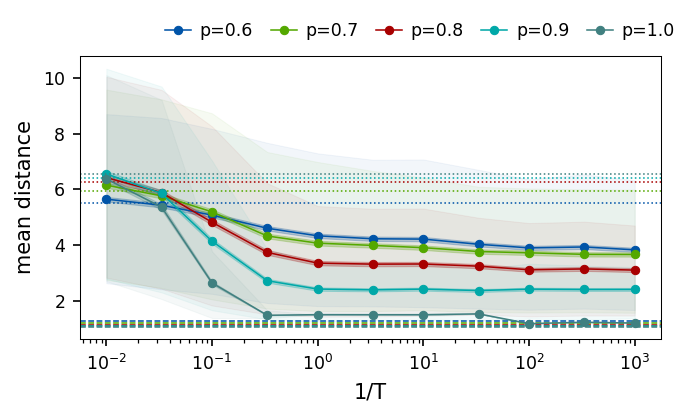

In [1121]:
LOQ = 0.16
UPQ = 1 - LOQ
PLOT_MEDIAN = False
PLOT_GRAPHS = False
SAVE_GRAPHS = False
SAVE_DISTANCES = True
COLORS = list(pcolors.values()) # ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    #      'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
mean_dists = []
for lsmh in sorted(list(lsmhtrials.keys())):
    for p in sorted(list(lsmhtrials[lsmh].keys())):
        print("%s: p=%.1f" % (lsmh, p))
        print("\tT\tmean\tsd\t{:.0f}%\t50%\t{:.0f}%".format(LOQ*100, UPQ*100))
        ts = []
        mns = []
        sds = []
        ups = []
        mds = []
        los = []
        if PLOT_GRAPHS:
            fig, ax = plt.subplots(2, len(t_range), figsize=(3*len(t_range), 6))
        for i, t in enumerate(sorted(list(lsmhtrials[lsmh][p].keys()))):
            trial = lsmhtrials[lsmh][p][t]
            ts.append(t)
            try:
                mn = np.mean(trial['distances'])
                sd = np.std(trial['distances'])/math.sqrt(len(trial['distances']))
                lo = np.quantile(trial['distances'], LOQ)
                md = np.quantile(trial['distances'], 0.50)
                up = np.quantile(trial['distances'], UPQ)
                mns.append(mn)
                sds.append(sd)
                los.append(lo)
                mds.append(md)
                ups.append(up)
                print("\t%.3f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (t, mn, sd, lo, mn, up))
            except:
                mns.append(np.NAN)
                sds.append(np.NAN)
                los.append(np.NAN)
                mds.append(np.NAN)
                ups.append(np.NAN)
            if PLOT_GRAPHS:
                try:
                    max_count = 1.0 * np.max(list(trial['counts'].values()))
                    weights = dict((tuple(trial['edges'][k]), trial['counts'][k] / max_count)
                                   for k in trial['counts'])
                    plot_graph(instances[instance], weights, 
                           axis=ax[0][i], linewidth=3.0, color=pcolors['blue'])
                    ax[1][i].hist(trial['distances'], density=True, bins=30)
                except Exception as e:
                    print("ERROR: %s" % e)
                ax[0][i].set_title('T=%.3f' % t, fontsize=12)
        mean_dists.append((p, ts, mns, sds, los, mds, ups))
        if SAVE_GRAPHS:
            for ext in ['png','pdf','svg']:
                plotfile = '../plots/ctp/ctp_travel_graph_%s_%s_%s_%.1f.%s' % \
                    (instance, lsmh, policy, p, ext)
                fig.savefig(plotfile,
                            bbox_inches='tight', dpi=600)
        plt.show()
    if len(mean_dists) > 0:
        fig = plt.figure(figsize=(5, 2.5))
        ax = fig.gca()
        ax.set_xscale("log")
        ax.set_xlabel("1/T")
        ax.set_ylabel("mean distance")
        for i, (p, ts, mns, sds, los, mds, ups) in enumerate(mean_dists):
            ts = np.array(ts)
            mns = np.array(mns)
            sds = np.array(sds)
            los = np.array(los)
            mds = np.array(mds)
            ups = np.array(ups)
            ax.fill_between(1/ts, los, ups, alpha=0.05, color=COLORS[i])
            ax.fill_between(1/ts, mns+3*sds, mns-3*sds, alpha=0.25, color=COLORS[i])
            if PLOT_MEDIAN:
                ax.plot(1/ts, mds, "-x", color=COLORS[i])
            ax.plot(1/ts, mns, "-o", label="p=%.1f" % p, color=COLORS[i])
            try:
                ax.axhline(np.mean(baselines['clairvoyant-agent'][p]['distances']), ls='dashed', color=COLORS[i])
                ax.axhline(np.mean(baselines['random-agent'][p]['distances']), ls='dotted', color=COLORS[i])
            except Exception as e:
                print("ERROR: no baselines for p=%s" % e)

        ax.legend(bbox_to_anchor=(0.15, 1.075, 0.9, .10), ncol=5, 
               handlelength=1.5, handletextpad=0.5, columnspacing=1.0)

        if SAVE_DISTANCES:
            for ext in ['png','pdf','svg']:
                plotfile = '../plots/ctp/ctp_travel_distances_%s_%s_%s.%s' % \
                    (instance, lsmh, policy, ext)
                plt.savefig(plotfile,
                            bbox_inches='tight', dpi=600)
        plt.show()

for b in baselines:
    for p in baselines[b]:
        print(b, p, np.mean(baselines[b][p]['distances']), np.std(baselines[b][p]['distances']))
